# 머신러닝 (Machine Learning)

## CNN(Convolutional Neural Network) - CIFAR10 데이터셋 분류 예제

### 1. 데이터 불러오기

In [36]:
# 모델을 사용하는 방식의 골자는 같습니다! 저번 시간에 했던 내용을 복습하듯 한번 실행해봅시다.
## 사용 라이브러리 불러오기

## numpy: 파이썬에서 사용하는 대표적인 연산 라이브러리로 "행렬" 연산을 가능하게 해줍니다.
import numpy as np
## torch: 딥러닝을 모델을 구축하는데 있어서 핵심이 되는 라이브러리로, numpy와 같은 기능을 하지만, GPU를 이용한 "병렬계산"이 가능한 것이 특징이자 강점입니다.
import torch
## torchvision: 딥러닝에서 유명한 데이터셋(torchvison.datasets)과 모델(torchvision.models), 그리고 이미지 전처리 코드(torchvision.transforms)가 저장되어 있는 라이브러리입니다.
## 오늘은 저번 시간과 다르게 데이터셋을 불러온 후 전처리를 진행해야합니다. 따라서 전처리를 위해 transforms 또한 불러와 줍시다.
from torchvision import datasets, transforms

In [37]:
# Train dataset과 Test dataset을 각각 불러옵니다.
# 이때, 우리가 torch를 이용하여 데이터를 병렬처리해야하므로 단순 array로 이루어진 이미지를 Tensor라는 torch 자료형으로 바꾸어주어야합니다.
# 이를 가능하게 해주는 것이 위에서 말씀드린 torchvision.transforms입니다.

## Transformers.ToTensor(): 데이터를 Tensor로 변경해줌
## Transformers.Resize((256, 256)): 이미지의 사이즈를 변경해줌 -> 모델의 크기를 잘 고
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


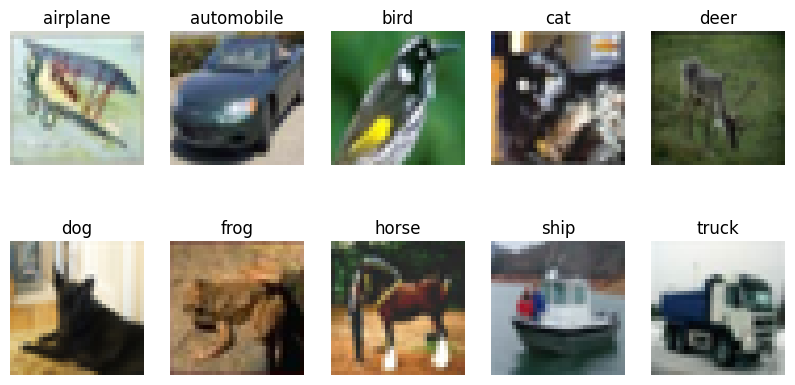

In [38]:
# 오늘도 시각화 툴을 이용하여 어떻게 생겼는지 확인해봅시다.
import matplotlib.pyplot as plt

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
figure = plt.figure(figsize=(10, 5))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    while label != i-1:
        sample_idx = torch.randint(len(trainset), size=(1,)).item()
        img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

신기합니다. 오늘 설명드린대로 10개의 다양한 물체의 이미지로 이루어져 있군요. 이제 우리가 늘 했던 것처럼 train 데이터를 나눠봅시다.

### 2. 데이터 분할 (Train to Train/Validation)

In [39]:
# 오늘도 seed 고정은 잊지마세요! 내 결과를 재현하기 위해서는 필수입니다.
# 오늘은 numpy를 사용하지 않으므로 torch seed를 고정해주겠습니다.

## seed 고정
def seed_fix(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_fix(0)

In [40]:
# train 데이터의 이미지 개수 확인
train_size = len(trainset)
print(train_size)

50000


In [41]:
# 반복적인 학습을 위해선 반복적인 Shuffle이 필요한 것을 기억하시죠?
# 오늘도 모든 데이터에 대해서 모두 학습하고, 한번 섞고, 다시 모든 데이터에 대해서 학습하는 방식을 사용하겠습니다.
# 저번에 사용했던 DataLoader와 random_split을 떠올리고, 이 두가지 라이브러리를 사용하여 학습을 위한 준비를 해봅시다.

## DataLoader, random_split 라이브러리 불러오기
from torch.utils.data import DataLoader, random_split

# 분할은 9:1로 진행합시다.
val_ratio = 0.1

## validation으로 사용할 데이터의 수 확인
split = int(train_size*val_ratio)

## 데이터 분할; random_split(데이터셋, [train 데이터의 수, validation 데이터의 수])
train_dataset, val_dataset = random_split(trainset, [train_size-split, split])

In [42]:
# 이제 데이터를 분할하여 불러오기위해 DataLoader를 사용해봅시다.

## train, validation, test dataloader로 변환
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=False)

In [43]:
# dataloader가 batch만큼 데이터를 가지고 있다는 것에 대해서 시각적으로 다시 한번 확인하겠습니다.

## dataloader 안의 데이터를 모두 순회(확인)
for idx, (data, label) in enumerate(train_dataloader):
    ## 너무 많으니 개수를 제한
    if idx < 4 or idx > 700:
        print(f'{idx+1}번째 data의 개수 >> {len(data)}')
    if idx == 4:
        print('...')

1번째 data의 개수 >> 64
2번째 data의 개수 >> 64
3번째 data의 개수 >> 64
4번째 data의 개수 >> 64
...
702번째 data의 개수 >> 64
703번째 data의 개수 >> 64
704번째 data의 개수 >> 8


### 3. 모델 구조(아키텍쳐) 설계

In [44]:
# 오늘은 CNN이라는 모델을 설계할겁니다.
# nn은 모델을 설계할 때 도움을 주는 라이브러리라는 것을 기억하고 계실까요?
# 모델의 설계를 위해서는 nn은 필수 요소입니다.
# 자 이제 한번 만들어볼까요?

## nn 라이브러리 불러오기
import torch.nn as nn

In [45]:
# 이 코드는 모델의 구조를 보여주는 코드입니다! 아래에서 실행해보면서 알아봅시다
from torchsummary import summary

In [46]:
# 모델 설계
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.Convolutional = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=3,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.Conv2d(
                in_channels=8,
                out_channels=16,
                kernel_size=3,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        self.fullyconnected =nn.Sequential(
            nn.Linear(8 * 8 * 16, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        x = self.Convolutional(x)
        x = x.view(-1, 8 * 8 * 16)
        x = self.fullyconnected(x)
        return x

In [52]:
summary(CNN().cuda(), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
              ReLU-2            [-1, 8, 32, 32]               0
         MaxPool2d-3            [-1, 8, 16, 16]               0
            Conv2d-4           [-1, 16, 16, 16]           1,168
              ReLU-5           [-1, 16, 16, 16]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Linear-7                   [-1, 64]          65,600
              ReLU-8                   [-1, 64]               0
            Linear-9                   [-1, 32]           2,080
             ReLU-10                   [-1, 32]               0
           Linear-11                   [-1, 10]             330
Total params: 69,402
Trainable params: 69,402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

아래에 나오는 코드는 저번에 사용했던 trianing 코드입니다. 코드의 자세한 설명이 필요하시면 직접 질문주시면 개별적으로 설명드리겠습니다

In [48]:
def train(model, dataloader, optim, criterion, device):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0

    for idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        pred = model(data)
        loss = criterion(pred, target)

        loss.backward()
        optim.step()
        optim.zero_grad()

        train_loss += loss.item()
        train_acc += (pred.argmax(1) == target).type(torch.float).sum().item()

    train_loss /= num_batches
    train_acc /= size

    print(f"Train: \n Accuracy: {(100*train_acc):>0.1f}%, Avg loss: {train_loss:>8f}")

def evaluation(model, dataloader, device, test=False):
    model.eval()
    size = len(dataloader.dataset)
    validation_acc = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            pred = model(data)

            validation_acc += (pred.argmax(1) == target).type(torch.float).sum().item()

    validation_acc /= size

    print(f"{'Test' if test else 'Validation'}: \n Accuracy: {(100*validation_acc):>0.1f}%\n")

    return validation_acc

### 4. 모델 학습

#### 4-1. CUDA 연결

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### 4-2. 학습 진행

In [50]:
## 모델 저장을 위한 라이브러리
import copy

# 우리가 만든 모델을 불러옵시다.
model = CNN().to(device)

# 또, 결과가 가장 좋았던 모델을 저장하기위해 가장 좋은 결과를 저장하는 변수와 모델을 저장하는 변수를 하나씩 만듭시다.
best_model = None
best_val_acc = 0

# loss를 계산하는 방식은 CrossEntropyLoss를 사용합시다.
criterion = nn.CrossEntropyLoss()

# 또한, 가중치를 업데이트하는 방식은 Adam을 사용합시다.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 가볍게 10번 정도 학습해봅시다. epoch는 반복횟수를 의미하는 단어입니다.
epochs = 10
print(f"Training Starts ...\nCNN || CrossEntropyLoss || Adam || CIFAR10\n")
for epoch in range(epochs):
    print(f'Epoch {epoch+1} >>>')
    train(model, train_dataloader, optimizer, criterion, device)
    val_acc = evaluation(model, val_dataloader, device)
    if val_acc > best_val_acc:
        best_model = copy.deepcopy(model)

Training Starts ...
CNN || CrossEntropyLoss || Adam || CIFAR10
Epoch 1 >>>
Train: 
 Accuracy: 34.1%, Avg loss: 1.798827
Validation: 
 Accuracy: 42.7%

Epoch 2 >>>
Train: 
 Accuracy: 45.0%, Avg loss: 1.511959
Validation: 
 Accuracy: 48.0%

Epoch 3 >>>
Train: 
 Accuracy: 50.2%, Avg loss: 1.382901
Validation: 
 Accuracy: 49.5%

Epoch 4 >>>
Train: 
 Accuracy: 53.5%, Avg loss: 1.293638
Validation: 
 Accuracy: 53.7%

Epoch 5 >>>
Train: 
 Accuracy: 56.5%, Avg loss: 1.217406
Validation: 
 Accuracy: 55.5%

Epoch 6 >>>
Train: 
 Accuracy: 58.7%, Avg loss: 1.162958
Validation: 
 Accuracy: 54.9%

Epoch 7 >>>
Train: 
 Accuracy: 60.6%, Avg loss: 1.113006
Validation: 
 Accuracy: 59.5%

Epoch 8 >>>
Train: 
 Accuracy: 61.8%, Avg loss: 1.073290
Validation: 
 Accuracy: 59.4%

Epoch 9 >>>
Train: 
 Accuracy: 63.0%, Avg loss: 1.037620
Validation: 
 Accuracy: 59.6%

Epoch 10 >>>
Train: 
 Accuracy: 64.2%, Avg loss: 1.010928
Validation: 
 Accuracy: 61.5%



In [51]:
# 성능이 점점 올라가는게 보는 재미가 있지 않나요?
# 이젠 저장된 모델을 이용하여 test 결과가 얼마나 나오는지 확인해봅시다!

test_acc = evaluation(best_model, test_dataloader, device, test=True)

Test: 
 Accuracy: 62.5%



저번시간에 해보았던 MLP보다는 이미지에 특화된 모델이기에 성능이 더 좋죠?<br><br>
물론 지금은 Transformer라는 아키텍쳐를 많이 사용하지만 CNN이 근본 이미지 모델이라는 점에서 학습의 필요성이 있습니다.<br><br>
오늘 사용한 코드를 보시면 저번에 작성한 코드랑 크게 바뀐 부분이 없죠? 두번째 읽는 코드라 더 익숙해졌을거라 생각합니다.<br><br>
이렇게 차근차근 모델을 사용하는 법을 배우고 학습할 수 있다면 활용도 머지 않았습니다! 오늘도 정말 고생하셨습니다 :)